In [33]:
data_set_path <- "/home/dmitry/Projects/DataSets/housing_kaggle"

In [34]:
library(visdat)
library(tidyverse)
library(tidymodels)
library(patchwork)
library(xgboost)

## Data import

In [35]:
train_data <- read_csv(paste(data_set_path, "train.csv", sep="/"))
test_data <- read_csv(paste(data_set_path, "test.csv", sep="/"))

Parsed with column specification:
cols(
  .default = col_character(),
  Id = col_double(),
  MSSubClass = col_double(),
  LotFrontage = col_double(),
  LotArea = col_double(),
  OverallQual = col_double(),
  OverallCond = col_double(),
  YearBuilt = col_double(),
  YearRemodAdd = col_double(),
  MasVnrArea = col_double(),
  BsmtFinSF1 = col_double(),
  BsmtFinSF2 = col_double(),
  BsmtUnfSF = col_double(),
  TotalBsmtSF = col_double(),
  `1stFlrSF` = col_double(),
  `2ndFlrSF` = col_double(),
  LowQualFinSF = col_double(),
  GrLivArea = col_double(),
  BsmtFullBath = col_double(),
  BsmtHalfBath = col_double(),
  FullBath = col_double()
  # ... with 18 more columns
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_character(),
  Id = col_double(),
  MSSubClass = col_double(),
  LotFrontage = col_double(),
  LotArea = col_double(),
  OverallQual = col_double(),
  OverallCond = col_double(),
  YearBuilt = col_double(),
  YearRemodA

## Tidy

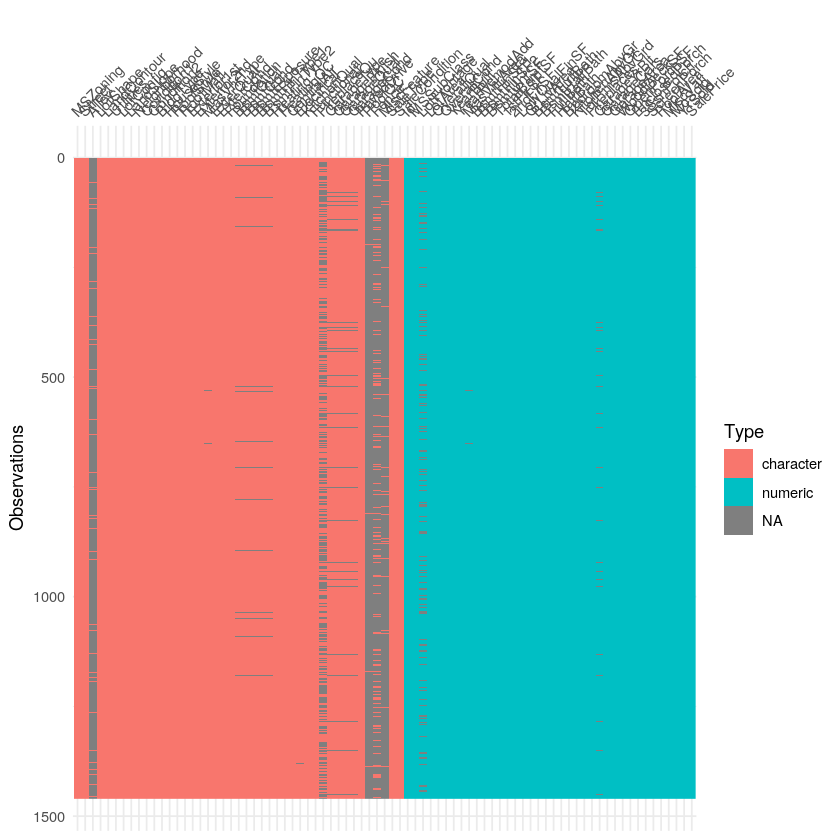

In [36]:
vis_dat(train_data)

In [37]:
library(DataExplorer)

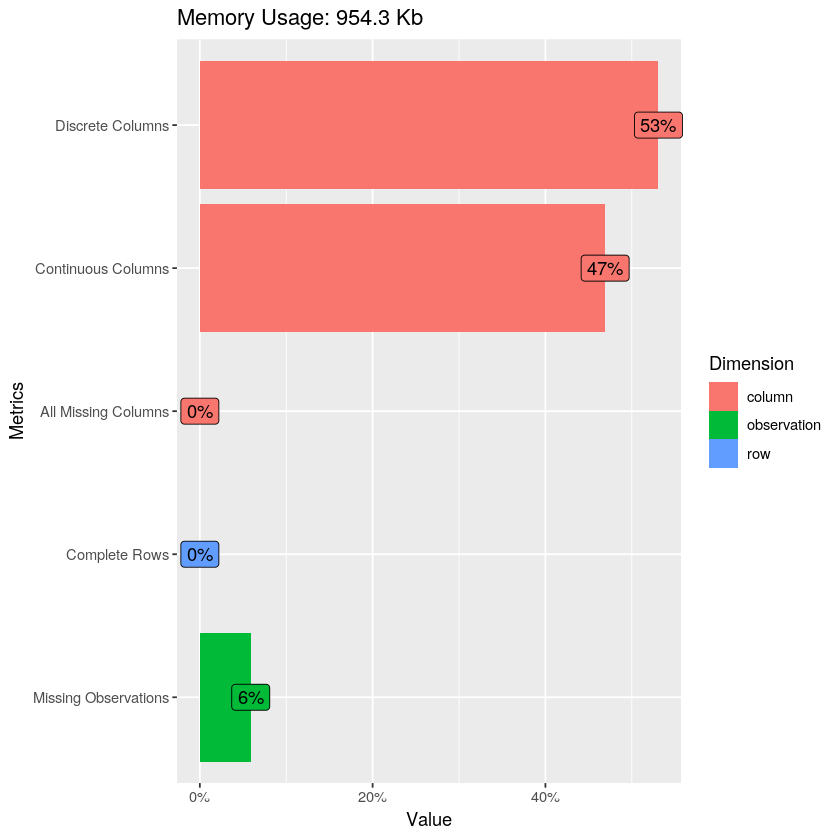

In [38]:
DataExplorer::plot_intro(train_data)

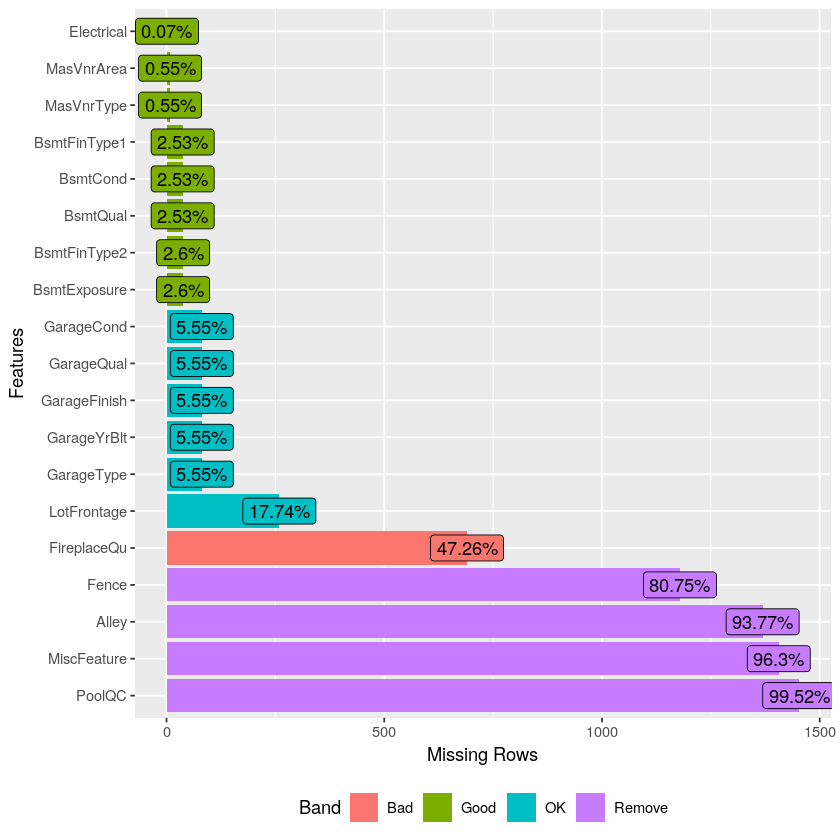

In [39]:
p <- DataExplorer::plot_missing(train_data, missing_only = T)
cols_to_remove <- p$data %>% filter(Band %in% c("Remove", "Bad")) %>% pull(feature)

In [40]:
cols_to_remove

[1] Alley       FireplaceQu PoolQC      Fence       MiscFeature
81 Levels: PoolQC MiscFeature Alley Fence FireplaceQu ... SalePrice

Lets analyse the line
"p$data %>% filter(Band %in% c("Remove", "Bad")) %>% pull(feature)"

So p$data is data.table which contains data columns as rows and the following values as columns:
feature - data feature name like Alley
num_missing - number of missed values
pct_missing - percentage of missed values
Band - shows level of missing values (OK, Good, Bad, Remove)

So first we filter data by Band
pull as an analogue of "[[ or $"
$ is a shorthand operator, where x$y is equivalent to x[["y", exact = FALSE]]
http://adv-r.had.co.nz/Subsetting.html#subsetting-operators

So pull(feature) take feature values (p$data %>% pull(feature))

## Target

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



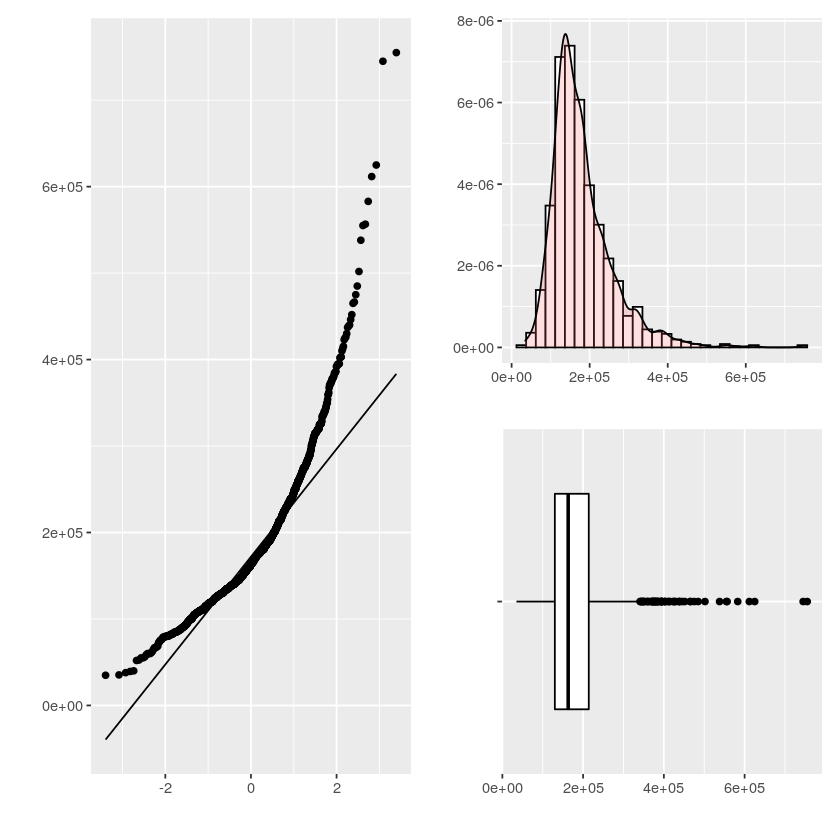

In [41]:
# hist
g1 <- ggplot(train_data, aes(x=SalePrice)) + 
 geom_histogram(aes(y=..density..), colour="black", fill="white")+
 geom_density(alpha=.2, fill="#FF6666")+ 
  labs(x = "", y = "")

# boxplot
g2 <- ggplot(train_data, aes(y=SalePrice)) + 
 geom_boxplot(aes(x=""), colour="black", fill="white")+
  coord_flip()+ 
  labs(x = "", y = "")

# qqplot
g3 <- ggplot(train_data, aes(sample = SalePrice))+ 
  stat_qq()+
  stat_qq_line()+ 
  labs(x = "", y = "")
  
g3 | g1 / g2 

Q-Q Plot (https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)
https://ggplot2.tidyverse.org/reference/geom_qq.html

So stat_qq shows dependence of SalePrice distribution on Normal distribution (stats::qnorm with default parameters, so sd=1)

As data argument is NULL in stat_qq, the data is inherited from the plot data as specified in the call to ggplot(), so SalePrice is used.

stat::qnorm is quantile function (https://en.wikipedia.org/wiki/Quantile_function)

So there are (https://rdrr.io/r/stats/Normal.html)
- dnorm gives the density
- pnorm gives the distribution function (https://en.wikipedia.org/wiki/Cumulative_distribution_function)
- qnorm gives the quantile function (https://en.wikipedia.org/wiki/Quantile_function) - it's Inverse distribution function
- rnorm generates random deviates.

### QQ Plot manually

Cheatlists for ggplot

https://github.com/rstudio/cheatsheets/blob/master/data-visualization-2.1.pdf

In [42]:
probs <- seq(0,1, length=1000)
x <- qnorm(probs)
y <- quantile(train_data$SalePrice, probs=probs)
qqdata = data.frame(norm=x, price=y)

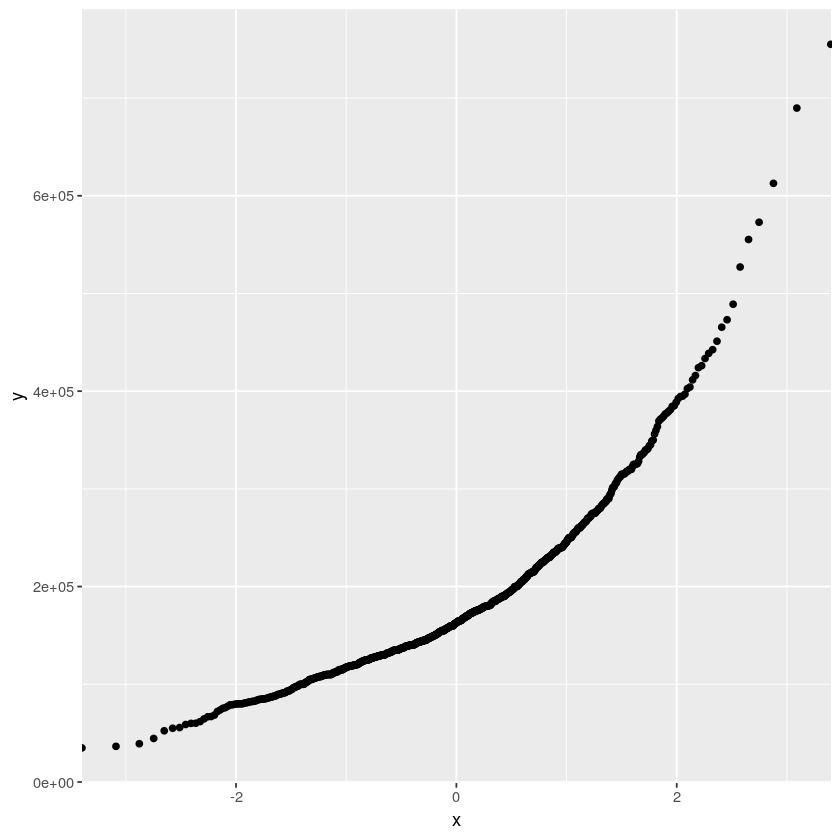

In [43]:
gm <- ggplot(qqdata, aes(x, y)) + geom_point()
gm

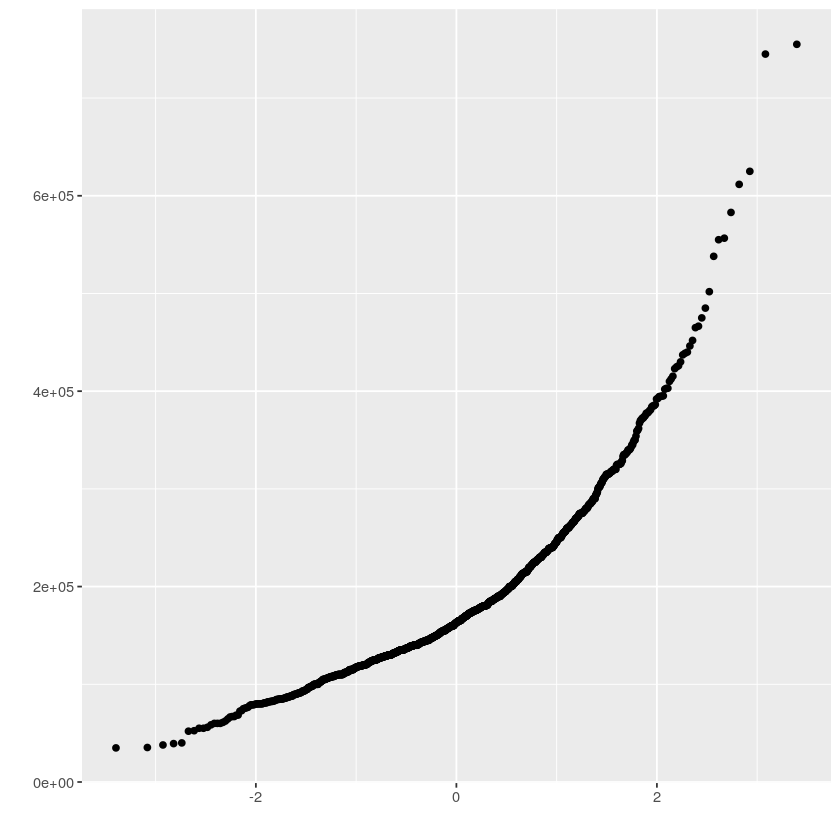

In [44]:
g3 <- ggplot(train_data, aes(sample = SalePrice))+ 
  stat_qq()+ 
  labs(x = "", y = "")
  
g3

What if we apply the log transformation?

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



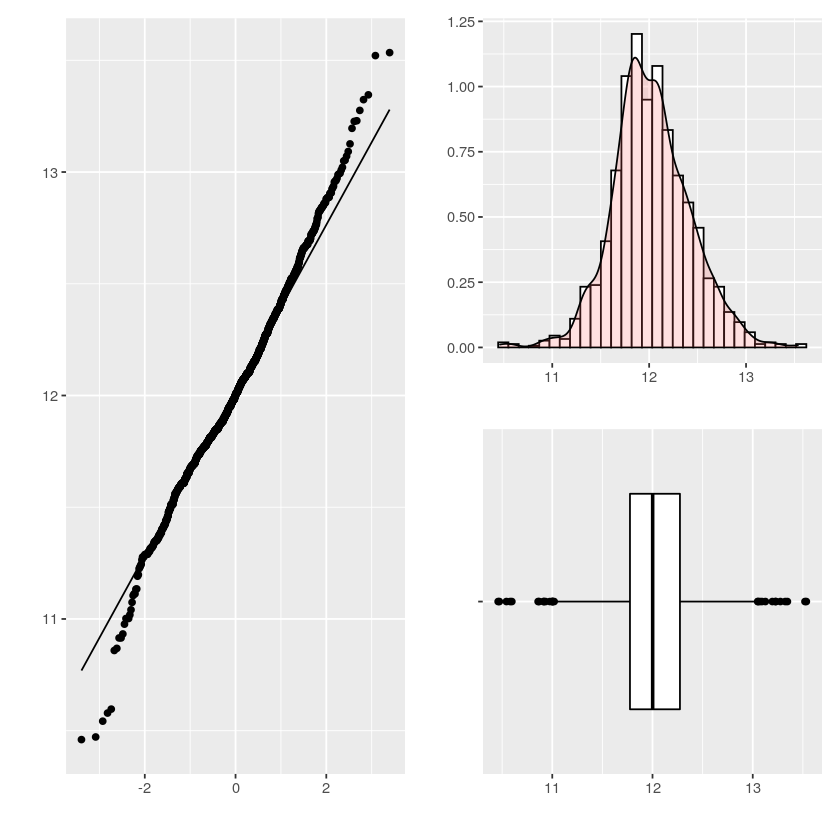

In [45]:
train_data <- train_data %>% mutate(SalePrice = log(SalePrice))

# hist
g1 <- ggplot(train_data, aes(x=SalePrice)) + 
 geom_histogram(aes(y=..density..), colour="black", fill="white")+
 geom_density(alpha=.2, fill="#FF6666")+ 
  labs(x = "", y = "")

# boxplot
g2 <- ggplot(train_data, aes(y=SalePrice)) + 
 geom_boxplot(aes(x=""), colour="black", fill="white")+
  coord_flip()+ 
  labs(x = "", y = "")

# qqplot
g3 <- ggplot(train_data, aes(sample = SalePrice))+ 
  stat_qq()+
  stat_qq_line()+ 
  labs(x = "", y = "")
  
g3 | g1 / g2 

So we see mutate function usage here

## Transform

Because we have formula "SalePrice ~ ." there are 2 roles - outcome for SalePrice and predictor for all other features

https://rdrr.io/cran/recipes/man/recipe.html

- step_rm - removes
- step_log- log transformation
- step_normalize - norm
- step_other - pools infrequently occurring values into an "other" category. (https://rdrr.io/cran/recipes/man/step_other.html)
- step_novel - https://rdrr.io/cran/recipes/man/step_novel.html
- step_knnimpute - creates a specification of a recipe step that will impute missing data using nearest neighbors. (https://rdrr.io/cran/recipes/man/step_knnimpute.html)
- step_dummy - converts nominal data (e.g. character or factors) into one or more numeric binary model terms for the levels of the original data. (https://rdrr.io/cran/recipes/man/step_dummy.html)

step_novel is for test data processing, for case when test data contains some new values for categorical features. (https://blog.datascienceheroes.com/how-to-use-recipes-package-for-one-hot-encoding/)

Books for reading:

- https://livebook.datascienceheroes.com/
- https://r4ds.had.co.nz/introduction.html


In [46]:
recipe(train_data, SalePrice ~ .) %>% summary()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
Id,numeric,predictor,original
MSSubClass,numeric,predictor,original
MSZoning,nominal,predictor,original
LotFrontage,numeric,predictor,original
LotArea,numeric,predictor,original
Street,nominal,predictor,original
Alley,nominal,predictor,original
LotShape,nominal,predictor,original
LandContour,nominal,predictor,original


In [47]:
SalePrice_recipe <- recipe(train_data, SalePrice ~ .) %>%
  step_rm(Id, Street, Utilities) %>% 
  step_rm(one_of(cols_to_remove)) %>%
  step_log(all_numeric(),-all_outcomes(), offset = 1) %>%
  step_normalize(all_numeric(),-all_outcomes()) %>%
  step_other(all_nominal(), -all_outcomes(), threshold = 0.01) %>%
  step_novel(all_predictors(), -all_numeric()) %>%
  step_knnimpute(all_predictors()) %>%
  step_dummy(all_nominal(), -all_outcomes()) 

## Model/Visualize

In [48]:
ncores <- 4

In [49]:
SalePrice_xgb_model <- 
  boost_tree(
  trees = tune(), learn_rate = tune(),
  tree_depth = tune(), min_n = tune(),
  loss_reduction = tune(), 
  sample_size = tune(), mtry = tune(),
  ) %>% 
  set_mode("regression") %>% 
  set_engine("xgboost", nthread = ncores)

https://www.tidymodels.org/learn/work/bayes-opt/

https://github.com/AnotherSamWilson/ParBayesianOptimization

https://juliasilge.com/blog/xgboost-tune-volleyball/

https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf


In [50]:
xgboost_params <- parameters(
  trees(), learn_rate(),
  tree_depth(), min_n(), 
  loss_reduction(),
  sample_size = sample_prop(), finalize(mtry(), train_data)  
)

xgboost_params <- xgboost_params %>% update(trees = trees(c(100, 500))) 

In [51]:
set.seed(123)
SalePrice_vfold <- vfold_cv(train_data, v = 5, strata = SalePrice)

In [52]:
workflow_SalePrice_xgb_model <- 
  workflow() %>% 
  add_model(SalePrice_xgb_model) %>% 
  add_recipe(SalePrice_recipe)

In [53]:
Sys.setlocale("LC_NUMERIC", "C")
# maybe better:?
# Sys.setlocale("LC_ALL", "C")

[1] "C"

In [54]:
set.seed(321)
xgboost_tune <-
  workflow_SalePrice_xgb_model %>%
  tune_bayes(
    resamples = SalePrice_vfold,
    param_info = xgboost_params,
    iter = 30, 
    metrics = metric_set(rmse, mape),
    control = control_bayes(no_improve = 10, 
                            save_pred = T, verbose = T)
  )



❯  Generating a set of 5 initial parameter results

✓ Initialization complete



Optimizing rmse using the expected improvement



── Iteration 1 ─────────────────────────────────────────────────────────────────



i Current best:		rmse=7.629 (@iter 0)

i Gaussian process model

✓ Gaussian process model

i Generating 5000 candidates

i Predicted candidates

i trees=120, learn_rate=0.0965, tree_depth=15, min_n=8, loss_reduction=3.6...

i Estimating performance

✓ Estimating performance

♥ Newest results:	rmse=0.13 (+/-0.00326)



── Iteration 2 ─────────────────────────────────────────────────────────────────



i Current best:		rmse=0.13 (@iter 1)

i Gaussian process model

✓ Gaussian process model

i Generating 5000 candidates

i Predicted candidates

i trees=199, learn_rate=1.3e-09, tree_depth=5, min_n=23, loss_reduction=2....

i Estimating performance

✓ Estimating performance

ⓧ Newest results:	rmse=11.53 (+/-0.00116)



── Iteration 3 ────────────────────────────────────────────

i Estimating performance

✓ Estimating performance

ⓧ Newest results:	rmse=11.51 (+/-0.00116)



── Iteration 15 ────────────────────────────────────────────────────────────────



i Current best:		rmse=0.1267 (@iter 10)

i Gaussian process model

✓ Gaussian process model

i Generating 5000 candidates

i Predicted candidates

i trees=372, learn_rate=5.41e-09, tree_depth=3, min_n=4, loss_reduction=3....

i Estimating performance

✓ Estimating performance

ⓧ Newest results:	rmse=11.53 (+/-0.00116)



── Iteration 16 ────────────────────────────────────────────────────────────────



i Current best:		rmse=0.1267 (@iter 10)

i Gaussian process model

✓ Gaussian process model

i Generating 5000 candidates

i Predicted candidates

i trees=270, learn_rate=6.08e-08, tree_depth=6, min_n=40, loss_reduction=0...

i Estimating performance

✓ Estimating performance

ⓧ Newest results:	rmse=11.53 (+/-0.00116)



── Iteration 17 ────────────────────────────────────────────────────────────────



i Cur

In [55]:
# This function has helped me to found difference between console and Jupyter I was searching for 4 hours before.
# I've found that locale differs for LC_NUMERIC
# Console has C, but Jupyter has ru_RU.UTF-8
# It caused tune_bayes didn't work in Jupyter with strange errors
# Error output width was cutted by 80 symbols, so I didn't see the reason.
# utils::sessionInfo()

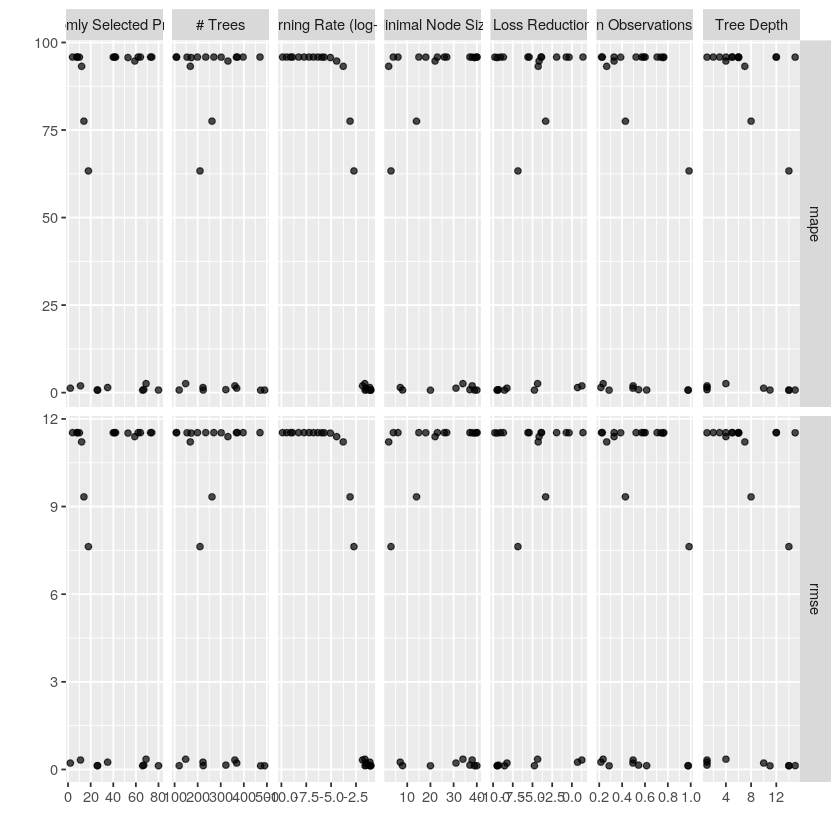

In [56]:
autoplot(xgboost_tune)

In [57]:
SalePrice_best_model <- select_best(xgboost_tune, "rmse", maximize = F)
print(SalePrice_best_model)

Warning message:
“The `maximize` argument is no longer needed. This value was ignored.”


# A tibble: 1 x 8
   mtry trees min_n tree_depth learn_rate loss_reduction sample_size .config
  <int> <int> <int>      <int>      <dbl>          <dbl>       <dbl> <fct>  
1    66   473    20         14     0.0263  0.00000000289       0.287 Model1 


In [58]:
SalePrice_final_model <- finalize_model(SalePrice_xgb_model, SalePrice_best_model)
SalePrice_workflow    <- workflow_SalePrice_xgb_model %>% update_model(SalePrice_final_model)
SalePrice_xgb_fit     <- fit(SalePrice_workflow, data = train_data)

In [62]:
pred <- 
  predict(SalePrice_xgb_fit, test_data) %>% 
  mutate(modelo = "XGBoost",
         .pred = exp(.pred))

In [67]:
read_csv(paste(data_set_path, "sample_submission.csv", sep="/")) %>%
  select(-SalePrice) %>% 
  bind_cols(pred %>% transmute(SalePrice = .pred)) %>% 
  write_csv(paste(data_set_path, "submission.csv"))

Parsed with column specification:
cols(
  Id = col_double(),
  SalePrice = col_double()
)

